In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
import json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bea3d4570d62d9e383dc8cb8f309eb20e90711bac57f5cc08c0d9f1ce19d65b5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TUMOR_TYPES = ['GLI', 'MET']


In [ ]:
def create_baseline_model(input_shape=(240, 240, 3)):
    """
    Creates a VGG16 model that directly predicts tumor type
    """
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add custom layers for tumor type prediction
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with softmax activation for multi-class prediction
    predictions = Dense(len(TUMOR_TYPES), activation='softmax', name='tumor_type')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [ ]:
def train_baseline_model(model, X_train, y_train, X_val, y_val, batch_size=16, epochs=75):
    """
    Train the baseline model for tumor type prediction
    """
    # Data augmentation
    data_gen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Compile model with categorical crossentropy for multi-class classification
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )

    return history


In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model's performance on test data
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Print performance metrics
    print("\nModel performance:")
    print("-" * 50)

    report = classification_report(
        y_test,
        y_pred,
        target_names=TUMOR_TYPES
    )
    print(report)

    # Calculate overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return y_pred, y_pred_prob


In [ ]:
def load_data_with_split(data_dirs, split_mapping, split_type="train"):
    """
    Load data from each view based on the split mapping
    """
    # Initialize data structures for each tumor type
    tumor_data = {'GLI': [], 'MET': []}
    tumor_labels = {'GLI': 0, 'MET': 1}

    # Process each tumor type
    for tumor_type in TUMOR_TYPES:
        # Get directory for this tumor type
        axial_dir = data_dirs['axial'][tumor_type]
        coronal_dir = data_dirs['coronal'][tumor_type]
        sagittal_dir = data_dirs['sagittal'][tumor_type]

        # Get all case IDs for this tumor type
        case_ids = set()
        for file_name in os.listdir(axial_dir):
            if file_name.endswith('.npz'):
                case_id = file_name.split('_')[0]
                case_ids.add(case_id)

        # Process each case
        for case_id in case_ids:
            # Skip if not in the requested split
            if case_id not in split_mapping or split_mapping[case_id] != split_type:
                continue

            # Try to load data for this case from each view
            case_data = {'axial': None, 'coronal': None, 'sagittal': None}

            # Check axial files
            for file_name in os.listdir(axial_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(axial_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['axial'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # Check coronal files
            for file_name in os.listdir(coronal_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(coronal_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['coronal'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # Check sagittal files
            for file_name in os.listdir(sagittal_dir):
                if file_name.startswith(case_id + '_') and file_name.endswith('.npz'):
                    file_path = os.path.join(sagittal_dir, file_name)
                    try:
                        data = np.load(file_path, allow_pickle=True)
                        case_data['sagittal'] = data['image']
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            # If we have data for all views, add to our dataset
            if case_data['axial'] is not None and case_data['coronal'] is not None and case_data['sagittal'] is not None:
                tumor_data[tumor_type].append({
                    'case_id': case_id,
                    'data': case_data,
                    'label': tumor_labels[tumor_type]
                })

    # Prepare final arrays
    X_axial = []
    X_coronal = []
    X_sagittal = []
    y_labels = []

    for tumor_type, cases in tumor_data.items():
        for case in cases:
            X_axial.append(case['data']['axial'])
            X_coronal.append(case['data']['coronal'])
            X_sagittal.append(case['data']['sagittal'])
            y_labels.append(case['label'])

    # Convert to numpy arrays
    X_axial = np.array(X_axial)
    X_coronal = np.array(X_coronal)
    X_sagittal = np.array(X_sagittal)
    y_labels = np.array(y_labels)

    return X_axial, X_coronal, X_sagittal, y_labels


In [ ]:
def load_synthetic_data(data_dirs, n_samples=90):
    """
    Load synthetic data for testing
    """
    # Define expected shapes
    axial_shape = (240, 240, 3)
    coronal_shape = (240, 155, 3)
    sagittal_shape = (240, 155, 3)

    # Lists to store data and labels
    X_axial, X_coronal, X_sagittal = [], [], []
    y_labels = []

    # Track counts per tumor type
    counts = {tumor_type: 0 for tumor_type in TUMOR_TYPES}

    for tumor_type in TUMOR_TYPES:
        label = TUMOR_TYPES.index(tumor_type)
        tumor_X_axial, tumor_X_coronal, tumor_X_sagittal = [], [], []

        # Load axial data
        axial_dir = data_dirs['axial'][tumor_type]
        axial_files = sorted([f for f in os.listdir(axial_dir) if f.endswith('.npz')])[:n_samples]
        for file_name in axial_files:
            try:
                file_path = os.path.join(axial_dir, file_name)
                data = np.load(file_path, allow_pickle=True)
                image = data['image']
                if image.shape == axial_shape:
                    tumor_X_axial.append(image)
                else:
                    print(f"Skipping {file_name} - Expected shape {axial_shape}, got {image.shape}")
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")

        # Load coronal data
        coronal_dir = data_dirs['coronal'][tumor_type]
        coronal_files = sorted([f for f in os.listdir(coronal_dir) if f.endswith('.npz')])[:n_samples]
        for file_name in coronal_files:
            try:
                file_path = os.path.join(coronal_dir, file_name)
                data = np.load(file_path, allow_pickle=True)
                image = data['image']
                if image.shape == coronal_shape:
                    tumor_X_coronal.append(image)
                else:
                    print(f"Skipping {file_name} - Expected shape {coronal_shape}, got {image.shape}")
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")

        # Load sagittal data
        sagittal_dir = data_dirs['sagittal'][tumor_type]
        sagittal_files = sorted([f for f in os.listdir(sagittal_dir) if f.endswith('.npz')])[:n_samples]
        for file_name in sagittal_files:
            try:
                file_path = os.path.join(sagittal_dir, file_name)
                data = np.load(file_path, allow_pickle=True)
                image = data['image']
                if image.shape == sagittal_shape:
                    tumor_X_sagittal.append(image)
                else:
                    print(f"Skipping {file_name} - Expected shape {sagittal_shape}, got {image.shape}")
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")

        # Find minimum count across all views for this tumor type
        min_count = min(len(tumor_X_axial), len(tumor_X_coronal), len(tumor_X_sagittal))
        counts[tumor_type] = min_count

        # Add only the samples that have all three views
        X_axial.extend(tumor_X_axial[:min_count])
        X_coronal.extend(tumor_X_coronal[:min_count])
        X_sagittal.extend(tumor_X_sagittal[:min_count])
        y_labels.extend([label] * min_count)

    print(f"Samples per tumor type: {counts}")

    # Convert to numpy arrays
    X_axial = np.array(X_axial)
    X_coronal = np.array(X_coronal)
    X_sagittal = np.array(X_sagittal)
    y_labels = np.array(y_labels)

    return X_axial, X_coronal, X_sagittal, y_labels


In [ ]:
def create_multi_view_model(axial_shape=(240, 240, 3), coronal_shape=(240, 155, 3), sagittal_shape=(240, 155, 3)):
    """
    Creates a multi-view model that combines features from all three views
    """
    # Create individual models for each view with unique name prefixes
    axial_input = Input(shape=axial_shape)
    axial_base = VGG16(weights='imagenet', include_top=False, input_tensor=axial_input, name='axial_vgg')
    for layer in axial_base.layers:
      layer.name = layer.name + str('_A')
    axial_base.trainable = False
    axial_features = Flatten(name='axial_flatten')(axial_base.output)
    axial_features = Dense(512, activation='relu', name='axial_dense1')(axial_features)
    axial_features = Dropout(0.5, name='axial_dropout1')(axial_features)
    axial_features = Dense(256, activation='relu', name='axial_dense2')(axial_features)

    coronal_input = Input(shape=coronal_shape)
    coronal_base = VGG16(weights='imagenet', include_top=False, input_tensor=coronal_input, name='coronal_vgg')
    for layer in coronal_base.layers:
      layer.name = layer.name + str('_C')
    coronal_base.trainable = False
    coronal_features = Flatten(name='coronal_flatten')(coronal_base.output)
    coronal_features = Dense(512, activation='relu', name='coronal_dense1')(coronal_features)
    coronal_features = Dropout(0.5, name='coronal_dropout1')(coronal_features)
    coronal_features = Dense(256, activation='relu', name='coronal_dense2')(coronal_features)

    sagittal_input = Input(shape=sagittal_shape)
    sagittal_base = VGG16(weights='imagenet', include_top=False, input_tensor=sagittal_input, name='sagittal_vgg')
    for layer in sagittal_base.layers:
      layer.name = layer.name + str('_S')
    sagittal_base.trainable = False
    sagittal_features = Flatten(name='sagittal_flatten')(sagittal_base.output)
    sagittal_features = Dense(512, activation='relu', name='sagittal_dense1')(sagittal_features)
    sagittal_features = Dropout(0.5, name='sagittal_dropout1')(sagittal_features)
    sagittal_features = Dense(256, activation='relu', name='sagittal_dense2')(sagittal_features)

    # Combine features from all views
    combined_features = Concatenate(name='concat_features')([axial_features, coronal_features, sagittal_features])

    # Add fully connected layers for classification
    x = Dense(512, activation='relu', name='combined_dense1')(combined_features)
    x = Dropout(0.5, name='combined_dropout1')(x)
    x = Dense(256, activation='relu', name='combined_dense2')(x)
    x = Dropout(0.3, name='combined_dropout2')(x)
    x = Dense(128, activation='relu', name='combined_dense3')(x)
    x = Dropout(0.2, name='combined_dropout3')(x)

    # Output layer
    predictions = Dense(len(TUMOR_TYPES), activation='softmax', name='output')(x)

    # Create the model
    model = Model(inputs=[axial_input, coronal_input, sagittal_input], outputs=predictions)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
def train_model():
    # Define data directories
    data_dir_axial = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes/Axial/GLI_axial',
        'MET': '/content/drive/MyDrive/npzs-all-planes/Axial/MET_axial',

    }

    data_dir_coronal = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes/Coronal/GLI_coronal',
        'MET': '/content/drive/MyDrive/npzs-all-planes/Coronal/MET_coronal',

    }

    data_dir_sagittal = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes/Sagittal/GLI_sagittal',
        'MET': '/content/drive/MyDrive/npzs-all-planes/Sagittal/MET_sagittal',

    }

    data_dir_axial_syn = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/GLI_axial_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/MET_axial_synthetic',

    }

    data_dir_coronal_syn = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/GLI_coronal_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/MET_coronal_synthetic',

    }

    data_dir_sagittal_syn = {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/GLI_sagittal_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/MET_sagittal_synthetic',

    }

    # Organize directories
    train_dirs = {
        'axial': data_dir_axial,
        'coronal': data_dir_coronal,
        'sagittal': data_dir_sagittal
    }

    test_dirs = {
        'axial': data_dir_axial_syn,
        'coronal': data_dir_coronal_syn,
        'sagittal': data_dir_sagittal_syn
    }

    # Load split mapping
    with open("/content/drive/MyDrive/split_mapping.json", "r") as json_file:
        split_mapping = json.load(json_file)

    # Load training data
    print("Loading training data...")
    X_train_axial, X_train_coronal, X_train_sagittal, y_train = load_data_with_split(
        train_dirs, split_mapping, "train"
    )

    # Create validation split
    print("Creating validation split...")
    indices = np.arange(len(y_train))
    train_idx, val_idx = train_test_split(indices, test_size=0.15, random_state=42, stratify=y_train)

    X_val_axial = X_train_axial[val_idx]
    X_val_coronal = X_train_coronal[val_idx]
    X_val_sagittal = X_train_sagittal[val_idx]
    y_val = y_train[val_idx]

    X_train_axial = X_train_axial[train_idx]
    X_train_coronal = X_train_coronal[train_idx]
    X_train_sagittal = X_train_sagittal[train_idx]
    y_train = y_train[train_idx]

    # Load test data (synthetic)
    print("Loading synthetic test data...")
    X_test_axial, X_test_coronal, X_test_sagittal, y_test = load_synthetic_data(test_dirs, n_samples=75)

    # Print dataset sizes
    print("\nDataset Sizes:")
    print(f"Training set: {len(y_train)} samples")
    print(f"Validation set: {len(y_val)} samples")
    print(f"Test set: {len(y_test)} samples")

    # Create multi-view model
    print("\nCreating multi-view model...")
    multi_view_model = create_multi_view_model()

    # Print model summary
    # multi_view_model.summary()

    # Train the model
    print("\nTraining multi-view model...")
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6
    )

    history = multi_view_model.fit(
        [X_train_axial, X_train_coronal, X_train_sagittal],
        y_train,
        validation_data=([X_val_axial, X_val_coronal, X_val_sagittal], y_val),
        batch_size=16,
        epochs=75,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate on test data
    print("\nEvaluating on synthetic test data...")
    test_loss, test_acc = multi_view_model.evaluate(
        [X_test_axial, X_test_coronal, X_test_sagittal],
        y_test
    )
    print(f"Test accuracy: {test_acc:.4f}")

    # Get detailed evaluation
    y_pred_prob = multi_view_model.predict([X_test_axial, X_test_coronal, X_test_sagittal])
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=TUMOR_TYPES))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

     # Apply LIME and SHAP for model explainability
    print("\nGenerating LIME and SHAP explanations...")
    generate_lime_explanations(multi_view_model, X_test_axial, X_test_coronal, X_test_sagittal, y_test)
    generate_shap_explanations(multi_view_model, X_test_axial, X_test_coronal, X_test_sagittal, y_test)


    # Save the model
    multi_view_model.save('/content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras')
    print("Model saved to: /content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras")


In [ ]:
def generate_lime_explanations(model, X_axial, X_coronal, X_sagittal, y_true, num_samples=5):
    """
    Generate LIME explanations for the multi-view model
    """
    # Import LIME
    import lime
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
    import matplotlib.pyplot as plt

    # Create a wrapper function for the model to work with LIME
    def model_predict_wrapper(images):
        # LIME expects a single input, but we need to create the other views
        # This is a simplified approach - we'll use LIME on one view at a time
        batch_size = images.shape[0]

        # Create dummy inputs for the other views (repeated from the first test sample)
        dummy_coronal = np.repeat(X_coronal[0:1], batch_size, axis=0)
        dummy_sagittal = np.repeat(X_sagittal[0:1], batch_size, axis=0)

        # Get predictions
        return model.predict([images, dummy_coronal, dummy_sagittal])

    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Select a few samples to explain
    indices = np.random.choice(len(y_true), min(num_samples, len(y_true)), replace=False)

    # Create directory for saving explanations
    save_dir = '/content/drive/MyDrive/explanations/lime'
    os.makedirs(save_dir, exist_ok=True)

    # Generate explanations for axial view
    for i, idx in enumerate(indices):
        image = X_axial[idx]
        true_label = y_true[idx]

        # Generate explanation
        explanation = explainer.explain_instance(
            image.astype('double'),
            model_predict_wrapper,
            top_labels=len(TUMOR_TYPES),
            hide_color=0,
            num_samples=1000
        )

        # Get the explanation for the true label
        temp, mask = explanation.get_image_and_mask(
            true_label,
            positive_only=True,
            num_features=10,
            hide_rest=False
        )

        # Plot the explanation
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f'Original - True: {TUMOR_TYPES[true_label]}')

        plt.subplot(1, 2, 2)
        plt.imshow(mark_boundaries(temp, mask))
        plt.title('LIME Explanation')

        # Save the figure
        plt.savefig(f'{save_dir}/lime_axial_sample_{i}.png')
        plt.close()

        print(f"LIME explanation for sample {i} (axial view) saved.")


In [ ]:
def load_model_and_explain(model_path, test_data_dirs, n_samples=10):
    """
    Load a saved model and generate LIME and SHAP explanations

    Parameters:
    - model_path: Path to the saved Keras model
    - test_data_dirs: Dictionary containing paths to test data
    - n_samples: Number of samples to explain
    """
    # Import required libraries
    import tensorflow as tf
    import numpy as np
    import os
    import matplotlib.pyplot as plt

    # Load the model
    print(f"Loading model from {model_path}...")
    model = tf.keras.models.load_model(model_path)

    # Load test data
    print("Loading test data...")
    X_test_axial, X_test_coronal, X_test_sagittal, y_test = load_synthetic_data(test_data_dirs, n_samples=75)

    # Print dataset info
    print(f"Test data loaded: {len(y_test)} samples")
    print(f"Classes: {TUMOR_TYPES}")

    #Generate predictions
    print("Generating predictions...")
    y_pred_prob = model.predict([X_test_axial, X_test_coronal, X_test_sagittal])
    y_pred = np.argmax(y_pred_prob, axis=1)

    # # Print performance metrics
    # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    # print("\nModel performance:")
    # print("-" * 50)

    # report = classification_report(
    #     y_test,
    #     y_pred,
    #     target_names=TUMOR_TYPES
    # )
    # print(report)

    # # Calculate overall accuracy
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"\nOverall Accuracy: {accuracy:.4f}")

    # # Print confusion matrix
    # print("\nConfusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Generate explanations
    # print("\nGenerating LIME explanations...")
    # generate_lime_explanations(model, X_test_axial, X_test_coronal, X_test_sagittal, y_test, num_samples=n_samples)

    print("\nGenerating SHAP explanations...")


    return model, X_test_axial, X_test_coronal, X_test_sagittal, y_test, y_pred


In [ ]:
test_dirs = {
    'axial': {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/GLI_axial_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Axial/MET_axial_synthetic',
    },
    'coronal': {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/GLI_coronal_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Coronal/MET_coronal_synthetic',
    },
    'sagittal': {
        'GLI': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/GLI_sagittal_synthetic',
        'MET': '/content/drive/MyDrive/npzs-all-planes-synthetic/Sagittal/MET_sagittal_synthetic',
    }
}

print("Loading test data...")
X_test_axial, X_test_coronal, X_test_sagittal, y_test = load_synthetic_data(test_dirs, n_samples=75)

# Path to your saved model
model_path = '/content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras'

Loading test data...
Skipping BraTS-MET-00595-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (400, 90, 3)
Skipping BraTS-MET-00694-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (288, 90, 3)
Skipping BraTS-MET-00595-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 400, 3)
Skipping BraTS-MET-00694-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 288, 3)
Samples per tumor type: {'GLI': 75, 'MET': 73}


In [ ]:
model_path = '/content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras'
print(f"Loading model from {model_path}...")
model = tf.keras.models.load_model(model_path)

Loading model from /content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras...


In [ ]:


# Load model and generate explanations
model, X_test_axial, X_test_coronal, X_test_sagittal, y_test, y_pred = load_model_and_explain(
    model_path,
    test_dirs,
    n_samples=10  # Number of samples to explain
)

Loading model from /content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras...
Loading test data...
Skipping BraTS-MET-00595-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (400, 90, 3)
Skipping BraTS-MET-00694-000_axial_largest_slice.npz - Expected shape (240, 240, 3), got (288, 90, 3)
Skipping BraTS-MET-00595-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 400, 3)
Skipping BraTS-MET-00694-000_sagittal_largest_slice.npz - Expected shape (240, 155, 3), got (90, 288, 3)
Samples per tumor type: {'GLI': 75, 'MET': 73}
Test data loaded: 148 samples
Classes: ['GLI', 'MET']
Generating predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step

Generating SHAP explanations...

Generating SHAP explanations for axial view...
Image shape: (240, 240, 3), Flattened size: 172800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.172e+01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.100e+01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 345600
Error processing sample 0 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.282e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 345600
Error processing sample 1 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
SHAP values size for class 0: 345600
Error processing sample 2 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
SHAP values size for class 0: 345600
Error processing sample 3 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.404e+00, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 345600
Error processing sample 4 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.296e+01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 345600
Error processing sample 5 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
SHAP values size for class 0: 345600
Error processing sample 6 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
SHAP values size for class 0: 345600
Error processing sample 7 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
SHAP values size for class 0: 345600
Error processing sample 8 for axial view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.181e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 345600
Error processing sample 9 for axial view: index 1 is out of bounds for axis 0 with size 1

Generating SHAP explanations for coronal view...
Image shape: (240, 155, 3), Flattened size: 111600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
SHAP values size for class 0: 223200
Error processing sample 0 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
SHAP values size for class 0: 223200
Error processing sample 1 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.376e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.799e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 2 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.276e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 3 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.158e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 4 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.173e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.131e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.736e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

SHAP values size for class 0: 223200
Error processing sample 5 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
SHAP values size for class 0: 223200
Error processing sample 6 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.305e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 7 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.279e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.953e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 8 for coronal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
SHAP values size for class 0: 223200
Error processing sample 9 for coronal view: index 1 is out of bounds for axis 0 with size 1

Generating SHAP explanations for sagittal view...
Image shape: (240, 155, 3), Flattened size: 111600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.877e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 0 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
SHAP values size for class 0: 223200
Error processing sample 1 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.567e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.312e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 2 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.258e+00, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 3 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.191e+00, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 4 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
SHAP values size for class 0: 223200
Error processing sample 5 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.520e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.385e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 6 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.718e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 7 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
SHAP values size for class 0: 223200
Error processing sample 8 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.500e+00, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values size for class 0: 223200
Error processing sample 9 for sagittal view: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "<ipython-input-40-eeaccf6ade9e>", line 77, in generate_shap_explanations
    shap_size = shap_values[class_idx].size
                ~~~~~~~~~~~^^^^^^^^^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


In [ ]:
# Get the axial branch of the model
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the model
model_path = '/content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras'
print(f"Loading model from {model_path}...")
model = tf.keras.models.load_model(model_path)
inputs = model.inputs
# coronal_input = model.get_layer('input_layer_1_C').input
# sagittal_input = model.get_layer('input_layer_2_S').input

axial_features = model.get_layer('axial_dense2').output

# Create a separate model for just the axial branch
axial_model = Model(inputs=inputs, outputs=axial_features)

Loading model from /content/drive/MyDrive/models/baseline_multi_view_model_2_class.keras...


In [ ]:
def get_axial_features(axial_image, coronal_image, sagittal_image):
    """
    Get the features from the axial branch for a single sample
    """
    # Add batch dimension if needed
    if len(axial_image.shape) == 3:
        axial_image = np.expand_dims(axial_image, axis=0)
    if len(coronal_image.shape) == 3:
        coronal_image = np.expand_dims(coronal_image, axis=0)
    if len(sagittal_image.shape) == 3:
        sagittal_image = np.expand_dims(sagittal_image, axis=0)

    # Get features
    features = axial_model.predict([axial_image, coronal_image, sagittal_image])
    return features



Creating background distribution...
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Background shape: (100, 60, 60, 256)

Creating explainer...

Getting SHAP values...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_178
Received: inputs=['Tensor(shape=(1, 60, 60, 256))']
  warnings.warn(msg)


to_explain shape: (1, 60, 60, 256)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_178
Received: inputs=['Tensor(shape=(50, 60, 60, 256))']
  warnings.warn(msg)


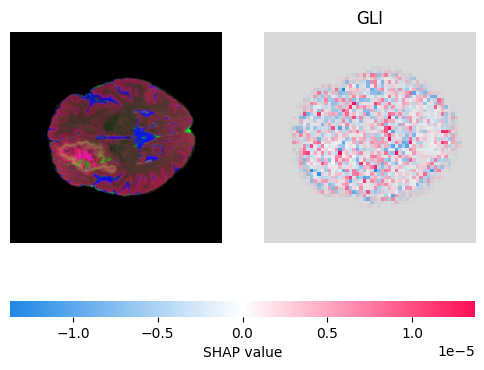

In [ ]:
import shap
import tensorflow as tf

# Choose a layer from the axial pathway
target_layer = 'block3_conv3_A'

# Create a model that goes from the target layer to a final prediction
layer_input = tf.keras.Input(shape=(60, 60, 256))  # Shape from the layer's input shape

# Define the layers we need
x = layer_input
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)  # 2 classes: GLI and MET

# Create the completion model
completion_model = tf.keras.Model(inputs=layer_input, outputs=x)

def map2layer(x_axial, layer_name):
    """Maps axial input to a specific layer's input"""
    intermediate_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.get_layer(layer_name).input
    )

    batch_size = len(x_axial)
    repeated_coronal = np.repeat(X_test_coronal[0:1], batch_size, axis=0)
    repeated_sagittal = np.repeat(X_test_sagittal[0:1], batch_size, axis=0)

    return intermediate_model.predict([
        x_axial,
        repeated_coronal,
        repeated_sagittal
    ])

# Create background distribution
print("\nCreating background distribution...")
background = map2layer(X_test_axial[:100], target_layer)
print(f"Background shape: {background.shape}")

# Create the explainer
print("\nCreating explainer...")
e = shap.GradientExplainer(
    (completion_model.input, completion_model.output),
    background
)

# Get SHAP values for a sample
print("\nGetting SHAP values...")
sample_idx = 0
to_explain = map2layer(X_test_axial[sample_idx:sample_idx+1], target_layer)
print(f"to_explain shape: {to_explain.shape}")

# Get SHAP values without ranked outputs first
# Get SHAP values without ranked outputs first
shap_values = e.shap_values(to_explain)

# Reshape SHAP values to match expected format
shap_values_reshaped = [sv.transpose(3, 0, 1, 2) for sv in shap_values]  # Move class dimension to front

# Get class names
class_names = ['GLI', 'MET']

# Plot the explanations
shap.image_plot(shap_values_reshaped, X_test_axial[sample_idx:sample_idx+1], class_names)


Creating background distribution...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Background shape: (100, 240, 240, 3)

Creating explainer...

Getting SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
to_explain shape: (1, 240, 240, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_196
Received: inputs=['Tensor(shape=(1, 240, 240, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_196
Received: inputs=['Tensor(shape=(50, 240, 240, 3))']
  warnings.warn(msg)


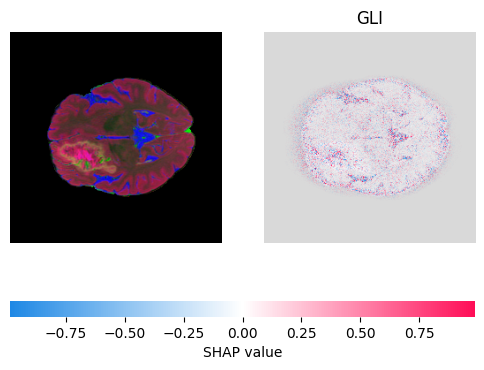

In [ ]:
import shap
import tensorflow as tf

# Choose a layer from the axial pathway
target_layer = 'input_layer_A'

# Create a model that goes from the target layer to a final prediction
layer_input = tf.keras.Input(shape=(240, 240, 3))

# Define the layers we need
x = layer_input
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)  # 2 classes: GLI and MET

# Create the completion model
completion_model = tf.keras.Model(inputs=layer_input, outputs=x)

def map2layer(x_axial, layer_name):
    """Maps axial input to a specific layer's input"""
    intermediate_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.get_layer(layer_name).output
    )

    batch_size = len(x_axial)
    repeated_coronal = np.repeat(X_test_coronal[0:1], batch_size, axis=0)
    repeated_sagittal = np.repeat(X_test_sagittal[0:1], batch_size, axis=0)

    return intermediate_model.predict([
        x_axial,
        repeated_coronal,
        repeated_sagittal
    ])

# Create background distribution
print("\nCreating background distribution...")
background = map2layer(X_test_axial[:100], target_layer)
print(f"Background shape: {background.shape}")

# Create the explainer
print("\nCreating explainer...")
e = shap.GradientExplainer(
    (completion_model.input, completion_model.output),
    background
)

# Get SHAP values for a sample
print("\nGetting SHAP values...")
sample_idx = 0
to_explain = map2layer(X_test_axial[sample_idx:sample_idx+1], target_layer)
print(f"to_explain shape: {to_explain.shape}")

# Get SHAP values without ranked outputs first
# Get SHAP values without ranked outputs first
shap_values = e.shap_values(to_explain)

# Reshape SHAP values to match expected format
shap_values_reshaped = [sv.transpose(3, 0, 1, 2) for sv in shap_values]  # Move class dimension to front

# Get class names
class_names = ['GLI', 'MET']

scale_factor = 1000  # Adjust this value as needed
shap_values_scaled = [sv * scale_factor for sv in shap_values_reshaped]


# Plot the explanations
shap.image_plot(shap_values_scaled, X_test_axial[sample_idx:sample_idx+1], class_names)

In [ ]:
import shap
import tensorflow as tf

# Choose a layer from the axial pathway
target_layer = 'input_layer_A'

# Create a model that goes from the target layer to a final prediction
layer_input = tf.keras.Input(shape=(240, 240, 3))

# Define the layers we need
x = layer_input
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)  # 2 classes: GLI and MET

# Create the completion model
completion_model = tf.keras.Model(inputs=layer_input, outputs=x)

def get_segments(image):
    segments = slic(image, n_segments=50, compactness=30, sigma=3)
    return segments

# Create a masker that uses the segments
def custom_mask(mask, image):
    segments = get_segments(image)
    out = np.zeros(image.shape)
    for i in range(len(mask)):
        if mask[i] == 1:
            out[segments == i] = image[segments == i]
    return out

def f(x):
    batch_size = x.shape[0]
    repeated_coronal = np.repeat(X_test_coronal[0:1], batch_size, axis=0)
    repeated_sagittal = np.repeat(X_test_sagittal[0:1], batch_size, axis=0)
    return model.predict([x, repeated_coronal, repeated_sagittal])

# Create segments for the first image
segments = get_segments(X_test_axial[0])
# Create masker and explainer
masker = shap.maskers.Image("blur(16,16)", X_test_axial[0].shape)  # Try different kernel sizes like (8,8) or (32,32)
explainer = shap.Explainer(f, masker, output_names=['GLI', 'MET'])

# Generate SHAP values
shap_values = explainer(X_test_axial[0:2], max_evals=250, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

# Convert shap_values to the expected format
# print(shap_values)
shap_values_arr = shap_values.values  # Get the values
shap_values_arr = [shap_values_arr[..., i] for i in range(shap_values_arr.shape[-1])]  # Split into list of arrays per class
# Plot the explanations
shap.image_plot(shap_values_arr, X_test_axial[0:2], width=8, aspect=0.2)  # Adjust these values as needed


TypeError: Image.__init__() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
import shap
import tensorflow as tf
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Generate segments for the first image - increase n_segments to cover more of the image
segments_slic = slic(X_test_axial[1], n_segments=120, compactness=20, sigma=3)  # Adjusted parameters

def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    masked_images = mask_image(z, segments_slic, X_test_axial[0], 255)
    batch_size = masked_images.shape[0]
    repeated_coronal = np.repeat(X_test_coronal[1:2], batch_size, axis=0)
    repeated_sagittal = np.repeat(X_test_sagittal[1:2], batch_size, axis=0)
    return model.predict([masked_images, repeated_coronal, repeated_sagittal])

# Create explainer and get SHAP values
explainer = shap.KernelExplainer(f, np.zeros((1,100)))  # Adjusted to match n_segments
shap_values = explainer.shap_values(np.ones((1,100)), nsamples=2000)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


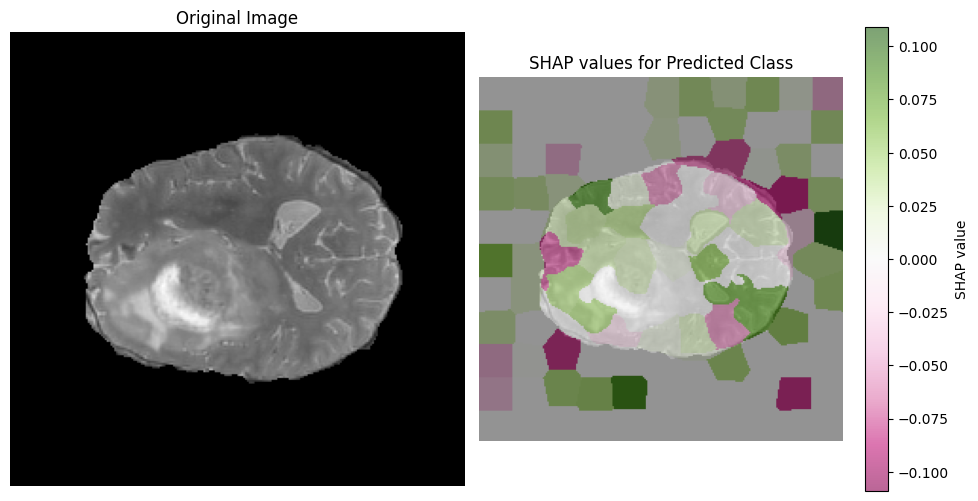

SHAP values shape: [(100, 2)]


In [ ]:
# Create visualization
plt.figure(figsize=(10,5))
gray_image = np.mean(X_test_axial[1], axis=-1)  # Simple averaging of RGB channels

# print("SHAP values statistics:")
# print("Min:", np.min(shap_values[0]))
# print("Max:", np.max(shap_values[0]))
# print("Mean:", np.mean(shap_values[0]))
# print("Distribution:", np.percentile(shap_values[0], [0, 25, 50, 75, 100]))


# Plot with symmetric value range around zero
shap_img = fill_segmentation(shap_values[0], segments_slic)
max_abs_val = np.max(np.abs(shap_img))  # Get maximum absolute value

# Original image
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# SHAP values for the predicted class
plt.subplot(122)
plt.imshow(gray_image, cmap='gray')
plt.imshow(fill_segmentation(shap_values[0], segments_slic),cmap='PiYG', alpha=0.6,
          vmin=-max_abs_val,  # symmetric negative range
          vmax=max_abs_val)   # symmetric positive rangeplt.title('SHAP values for Predicted Class')
plt.title('SHAP values for Predicted Class')
plt.axis('off')

plt.colorbar(label='SHAP value')
plt.tight_layout()
plt.show()

# Print the shape of SHAP values for debugging
print("SHAP values shape:", [sv.shape for sv in shap_values])

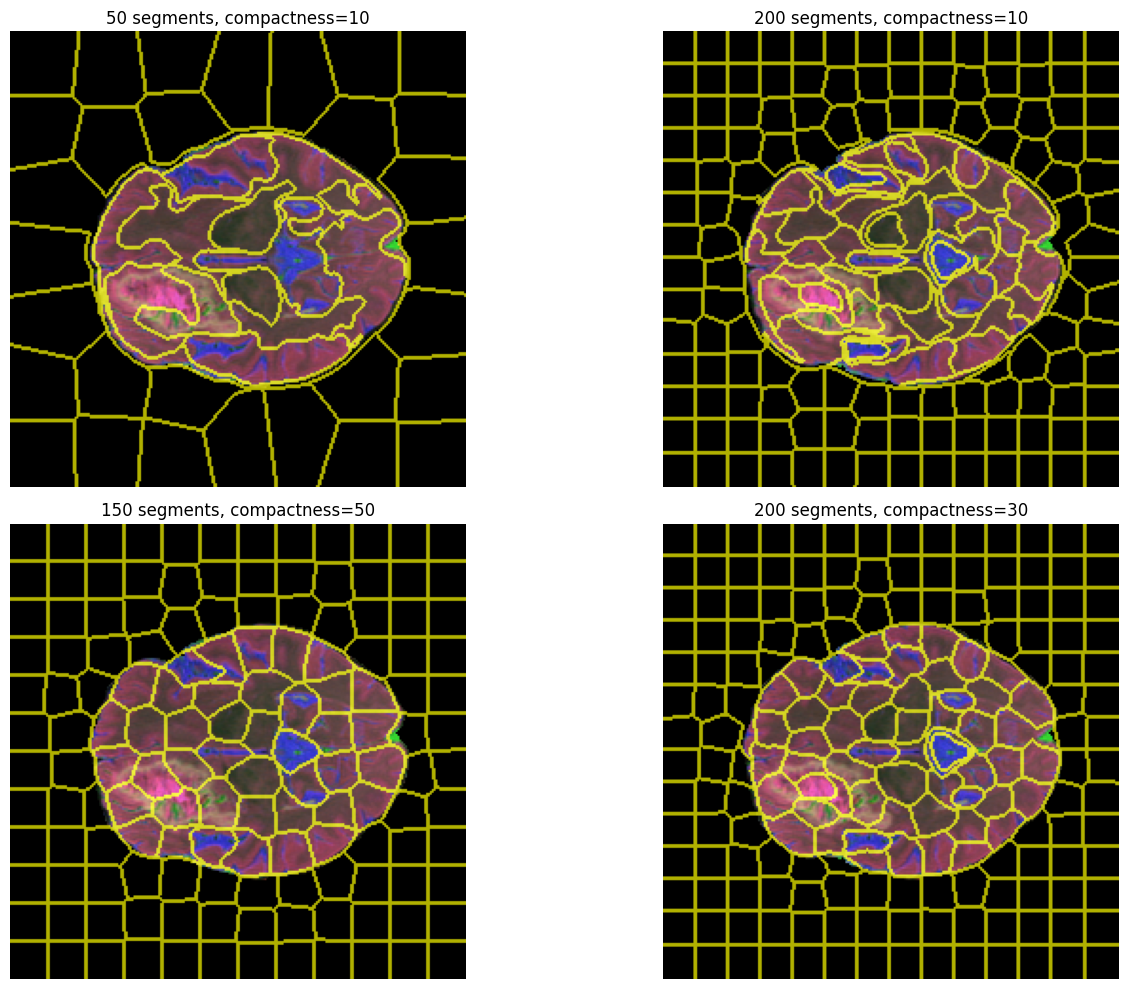

Number of segments in each image:
Image 1: 42
Image 2: 174
Image 3: 144
Image 4: 194


In [ ]:
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Convert image to grayscale for better visualization
gray_image = np.mean(X_test_axial[0], axis=-1)

# Try different segmentation parameters
segments_1 = slic(X_test_axial[0], n_segments=50, compactness=10, sigma=3)
segments_2 = slic(X_test_axial[0], n_segments=200, compactness=10, sigma=3)
segments_3 = slic(X_test_axial[0], n_segments=150, compactness=50, sigma=3)
segments_4 = slic(X_test_axial[0], n_segments=200, compactness=30, sigma=3)

# Create visualization
plt.figure(figsize=(15,10))

# Original with segments_1 (50 segments)
plt.subplot(221)
plt.imshow(gray_image, cmap='gray')
plt.imshow(mark_boundaries(X_test_axial[0], segments_1), alpha=0.7)
plt.title('50 segments, compactness=10')
plt.axis('off')

# Original with segments_2 (200 segments)
plt.subplot(222)
plt.imshow(gray_image, cmap='gray')
plt.imshow(mark_boundaries(X_test_axial[0], segments_2), alpha=0.7)
plt.title('200 segments, compactness=10')
plt.axis('off')

# Original with segments_3 (low compactness)
plt.subplot(223)
plt.imshow(gray_image, cmap='gray')
plt.imshow(mark_boundaries(X_test_axial[0], segments_3), alpha=0.7)
plt.title('150 segments, compactness=50')
plt.axis('off')

# Original with segments_4 (high compactness)
plt.subplot(224)
plt.imshow(gray_image, cmap='gray')
plt.imshow(mark_boundaries(X_test_axial[0], segments_4), alpha=0.7)
plt.title('200 segments, compactness=30')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print number of segments actually created
print(f"Number of segments in each image:")
print(f"Image 1: {len(np.unique(segments_1))}")
print(f"Image 2: {len(np.unique(segments_2))}")
print(f"Image 3: {len(np.unique(segments_3))}")
print(f"Image 4: {len(np.unique(segments_4))}")